In [43]:
# imports
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from numpy import random
import datetime
import seaborn as sns

In [2]:
household_data = pd.read_csv("./dataset/informations_households.csv", encoding="utf-8")
household_data.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


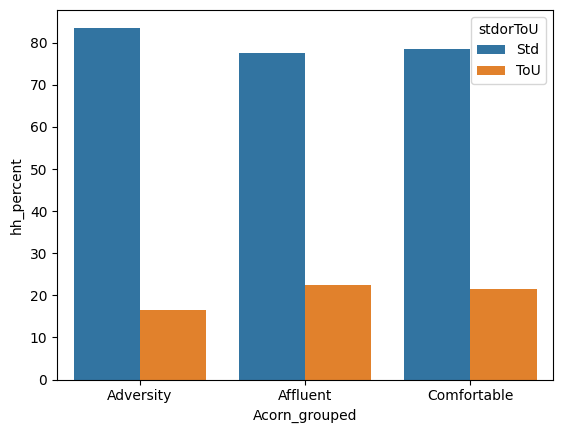

In [55]:
# Breakdown of Tarrif based on Affluency

affluency_df = household_data[household_data["Acorn_grouped"].isin(["Adversity", "Affluent", "Comfortable"])][["Acorn_grouped", "stdorToU", "LCLid"]]
affluency_count = affluency_df.groupby(["Acorn_grouped"]).count().reset_index()
affluency_grouped = affluency_df.groupby(["Acorn_grouped", "stdorToU"]).count().reset_index()
affluency_grouped["hh_count"] = affluency_grouped["Acorn_grouped"].apply(lambda a: affluency_grouped[affluency_grouped["Acorn_grouped"] == a]["LCLid"].sum())
affluency_grouped["hh_percent"] = affluency_grouped["LCLid"] / affluency_grouped["hh_count"] * 100

sns.barplot(x="Acorn_grouped", y="hh_percent", hue="stdorToU", data=affluency_grouped);


In [3]:
acorn_data = pd.read_csv("./dataset/acorn_details.csv", encoding="ISO-8859-1"
                         )
acorn_data.head()

,MAIN CATEGORIES,CATEGORIES,REFERENCE,ACORN-A,ACORN-B,ACORN-C,ACORN-D,ACORN-E,ACORN-F,ACORN-G,ACORN-H,ACORN-I,ACORN-J,ACORN-K,ACORN-L,ACORN-M,ACORN-N,ACORN-O,ACORN-P,ACORN-Q
0,POPULATION,Age,Age 0-4,77.0,83.0,72.0,100.0,120.0,77.0,97.0,97.0,63.0,119.0,67.0,114.0,113.0,89.0,123.0,138.0,133.0
1,POPULATION,Age,Age 5-17,117.0,109.0,87.0,69.0,94.0,95.0,102.0,106.0,67.0,95.0,64.0,108.0,116.0,86.0,89.0,136.0,106.0
2,POPULATION,Age,Age 18-24,64.0,73.0,67.0,107.0,100.0,71.0,83.0,89.0,62.0,104.0,459.0,97.0,96.0,86.0,117.0,109.0,110.0
3,POPULATION,Age,Age 25-34,52.0,63.0,62.0,197.0,151.0,66.0,90.0,88.0,63.0,132.0,145.0,109.0,96.0,90.0,140.0,120.0,120.0
4,POPULATION,Age,Age 35-49,102.0,105.0,91.0,124.0,118.0,93.0,102.0,103.0,76.0,111.0,67.0,99.0,98.0,90.0,102.0,103.0,100.0


In [4]:
hh_block_path = Path("./dataset/halfhourly_dataset/halfhourly_dataset/")

In [9]:
def get_data_from_block_files(filepath, file_count = 2):
    # Get a random set of files and concatenate

    block_list = list(filepath.glob("*.csv"))
    file_list = random.choice(block_list, file_count, replace=False)
    final_df = pd.DataFrame()
    for file in file_list:
        # read file and filter only 2013 data
        df = pd.read_csv(file, parse_dates=["tstp"])
        year_2013_mask = (df["tstp"] >= "2013-1-1") & (df["tstp"] <= "2013-12-31")
        final_df = pd.concat([final_df, df[year_2013_mask]])

    return final_df.reset_index(drop=True)
        

In [10]:
block_data = get_data_from_block_files(hh_block_path)

In [17]:
block_data.rename(columns={"tstp":"datetime", "energy(kWh/hh)":"kWh"}, inplace=True)
block_data["date"] = block_data["datetime"].dt.date
block_data["time"] = block_data["datetime"].apply(lambda a: a.strftime("%I:%M %p"))

# pivot the data
# df_pivoted = block_data.pivot_table(index = ["LCLid", "date"], columns=["time"], values=["kWh"], sort=False).reset_index()

In [20]:
merged_df = block_data.merge(household_data[["LCLid", "Acorn", "Acorn_grouped", "stdorToU"]], how="inner", left_on="LCLid", right_on="LCLid", copy=False, )

In [24]:
merged_df

,LCLid,datetime,kWh,date,time,Acorn,Acorn_grouped,stdorToU
0,MAC000120,2013-01-01 00:00:00,0,2013-01-01,12:00 AM,ACORN-E,Affluent,Std
1,MAC000120,2013-01-01 00:30:00,0,2013-01-01,12:30 AM,ACORN-E,Affluent,Std
2,MAC000120,2013-01-01 01:00:00,0,2013-01-01,01:00 AM,ACORN-E,Affluent,Std
3,MAC000120,2013-01-01 01:30:00,0,2013-01-01,01:30 AM,ACORN-E,Affluent,Std
4,MAC000120,2013-01-01 02:00:00,0,2013-01-01,02:00 AM,ACORN-E,Affluent,Std
...,...,...,...,...,...,...,...,...
1632748,MAC005562,2013-12-30 22:00:00,0.419,2013-12-30,10:00 PM,ACORN-F,Comfortable,Std
1632749,MAC005562,2013-12-30 22:30:00,0.384,2013-12-30,10:30 PM,ACORN-F,Comfortable,Std
1632750,MAC005562,2013-12-30 23:00:00,0.401,2013-12-30,11:00 PM,ACORN-F,Comfortable,Std
1632751,MAC005562,2013-12-30 23:30:00,0.385,2013-12-30,11:30 PM,ACORN-F,Comfortable,Std


In [ ]:
# Affluency anaylis
# Sesonal Analysis
# TOU Analysis
# Lifestyle Analysis
# House Charactersitics
